<a href="https://colab.research.google.com/github/nabeel-gulzar/binary_semantic_analysis/blob/main/Binary_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gdown
!gdown --id '1n0j5zbMXMVnLPUqadFNcCxiZRu0ChoXL'
!unzip Programming_Assignment_3.zip

# Imports

In [ ]:
import glob
import re
import numpy as np
import pandas as pd
from pathlib import Path
from time import time
from matplotlib import pyplot as plt
from math import floor

# Constants

In [ ]:
train_dir = 'Dataset/train/'
test_dir = 'Dataset/test/'
neg_words_path = 'Dataset/negative_words.txt'
pos_words_path = 'Dataset/positive_words.txt'
stop_words_path = 'Dataset/stop_words.txt'

neg_words = list()
pos_words = list()
stop_words = list()

# regex to remove punctuations
garbage_words_re = r"[();:',.\/@#$%*+!`^_0-9><\"]*"

In [ ]:
#reading auxilary data from files
with open(pos_words_path, 'r') as file:
  pos_words = file.read().split('\n')
with open(neg_words_path, 'r', encoding='Latin-1') as file:
  neg_words = file.read().split('\n')
with open(stop_words_path, 'r') as file:
  stop_words = file.read().split('\n')

In [ ]:
def preprocess_review(review):
  # split words and filter words that are not in stop words
  without_stop_words = ' '.join([token for token in review.split() if token not in stop_words])
  return re.sub(garbage_words_re, '', without_stop_words)

In [ ]:
def extract_features(directory):
  features = list()
  labels = list()
  for filename in glob.iglob(directory + '*/*.txt', recursive=True):
    with open(filename, 'r') as file:
      features.append([1,0,0])
      review = file.read()
      review = preprocess_review(review)
      for token in review.split():
        if token in pos_words:
          # if the word is in positive words list then increment x1 
          features[-1][1] = features[-1][1]+1
        elif token in neg_words:
          # if the word is in negative words list then increment x2
          features[-1][2] = features[-1][2]+1
      if filename.split('/')[-2] == 'pos':
        # if review if positive, add label 1
        labels.append(1)
      else:
        # if review if negative, add label 0
        labels.append(0)
  return np.array(features), np.array(labels)

# Feature Extraction and Preprocessing

In [ ]:
start_time = time()
train_X, train_Y = extract_features(train_dir)
print("Time taken to extract training features: {:.2f} seconds".format(time()-start_time))

start_time = time()
test_X, test_Y = extract_features(test_dir)
print("Time taken to extract test features: {:.2f} seconds".format(time()-start_time))

Time taken to extract training features: 222.45 seconds
Time taken to extract test features: 217.82 seconds


In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))
def predict(features, thetas):
  predicted = np.matmul(features, np.transpose(thetas))
  return sigmoid(predicted)
def cost(actual, predicted):
  # cross entropy loss
  return ((-actual*np.log(predicted))-((1-actual)*np.log(1-predicted))).mean()

In [ ]:
def gradient_descent(training_data, actual_labels, alpha, iterations):
  # initialize thetas
  thetas = np.array([0,0,0])
  # get training examples count
  training_size = actual_labels.size
  # initialize list to hold costs
  J = list()
  # iteration loop
  for i in range(iterations):
    # predict labels
    predicted_labels = predict(features=training_data, thetas=thetas)
    # append cost to the list of cost
    J.append(cost(actual=actual_labels, predicted=predicted_labels))
    # difference in actual and predicted value
    error = predicted_labels-actual_labels
    # sum of derivative w.r.t each theta
    sum_derivative = np.matmul(error, training_data)
    # simulteneous update of thetas
    thetas = thetas - ((alpha/training_size)*sum_derivative)
  # prediction with the optimal thetas
  predicted_labels = predict(features=training_data, thetas=thetas)
  # cost with the optimal thetas
  J.append(cost(actual=actual_labels, predicted=predicted_labels))
  return thetas, J

In [ ]:
def plot_cost(J, xlabel='Iteration', ylabel='Cost', title='Cost w.r.t iteration', xvalues=None):
    fig, ax = plt.subplots()
    # resize the figure
    fig.set_size_inches(16, 12)
    # set title
    ax.set_title(title)
    # set label of y axis
    plt.ylabel(ylabel)
    # set label of x axis
    plt.xlabel(xlabel)
    # check if values for x are provided to add custom ticks on x-axis
    if xvalues is None:
        xvalues = [i for i in range(len(J))]
    xticks = list(set([floor(v) for v in xvalues]))
    if len(xticks) > 10:
        np.arange(min(xticks), max(xvalues)+1, len(xticks)//10)
    plt.xticks()
    plt.plot(xvalues, J, '-')

In [ ]:
def assign_labels(raw_predictions):
  # assigns 1 if probability of 1 is greater than 1 otherwise 0
  f = lambda x: 1 if x > 0.5 else 0
  # vectorize the function f
  vf = np.vectorize(f)
  return vf(raw_predictions)

In [ ]:
def generate_confusion_matrix(gold, prediction, labels):
    """
    generates a confusion matrix
    Params:
    gold - vector of true labels
    predicted - vector of predicted labels
    labels: list of distinct labels
    Returns:
    confusion matrix with shape (label count X label count)
    """
    if len(gold) != len(prediction):
        print('label arrays should have same size')
        return
    label_count = len(labels)
    cm = np.zeros((label_count, label_count))
    for i in range(len(prediction)):
        cm[labels.index(prediction[i])][labels.index(gold[i])] += 1
    return cm
def compute_macro_average(prediction, gold, labels):
    """
    computes macro average (precision, recall, f1) confusion_matrix and accuracy
    Params:
    prediction - vector of predicted labels
    gold - vector of true labels
    labels: list of distinct labels
    Returns:
    dictionary of {precision, recall, f1, confusion_matrix, accuracy}
    """
    if len(gold) != len(prediction):
        print('label arrays should have same size')
        return
    label_count = len(labels)
    cm = generate_confusion_matrix(gold, prediction, labels)
    precision = 0
    recall = 0
    accuracy = 0
    for i in range(label_count):
        negatives = [n for n in range(label_count) if n != i]
        tp = cm[i][i]
        fn = np.array([cm[j][i] for j in negatives]).sum()
        fp = np.array([cm[i][j] for j in negatives]).sum()
        tn = np.array([np.array([cm[j][k] for j in negatives]).sum() for k in negatives]).sum()

        precision += (tp/(tp+fp))
        recall += (tp/(tp+fn))
        accuracy += tp
    accuracy = accuracy/len(prediction)
    macro_avg_precision = precision/label_count
    macro_avg_recall = recall/label_count
    f1_score = (2*macro_avg_precision*macro_avg_recall)/(macro_avg_precision+macro_avg_recall)
    return {'f1': f1_score,
            'precision': macro_avg_precision,
            'recall': macro_avg_recall,
            'accuracy': accuracy,
            'confusion_matrix': cm}

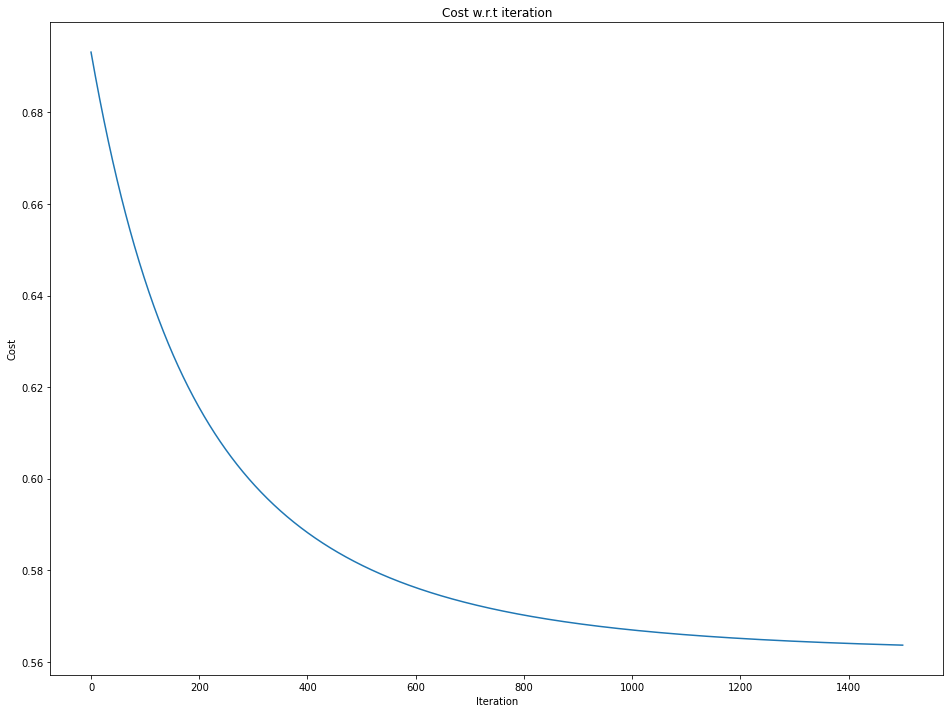

In [ ]:
# learning rate
alpha = 0.0005
# number of iterations
iterations = 1500
# function call to gradient descent functions
thetas, J = gradient_descent(training_data=train_X, actual_labels=train_Y, alpha=alpha, iterations=iterations)
# plot the cost with respect to iteration 
plot_cost(J)

# Performance on Test Data

In [ ]:
# prediction on the test features
predicted = predict(features=test_X, thetas=thetas)
# assign actual labels by applying threshold > 0.5
predicted = assign_labels(predicted)
# compute performance metrics and confusion matrix
perf = compute_macro_average(prediction=predicted, gold=test_Y, labels=[0,1])
print("Accuracy: {:.4f}".format(perf['accuracy']))
print("F1: {:.4f}".format(perf['f1']))
print("Precision: {:.4f}".format(perf['precision']))
print("Recall: {:.4f}".format(perf['recall']))

Accuracy: 0.7284
F1: 0.7286
Precision: 0.7287
Recall: 0.7284


In [ ]:
pd.DataFrame(data=perf['confusion_matrix'], columns=["Negative","Positive"], index=["Negative","Positive"])

,Negative,Positive
Negative,8877.0,3167.0
Positive,3623.0,9333.0


# Part 2: Logistic Regressions Using sklearn API

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
start_time = time()
#training function of sklearn logistic regression
lr = LogisticRegression().fit(train_X, train_Y)
print("Time taken to train with sklearn: {:.2f} seconds".format(time()-start_time))
prediction = lr.predict(test_X)
accuracy = accuracy_score(test_Y, prediction)
print("Accuracy on test: {}".format(accuracy))

Time taken to train with sklearn: 0.05 seconds
Accuracy on test: 0.72544


In [ ]:
confusion_mat = confusion_matrix(test_Y, prediction, [0,1])
pd.DataFrame(data=confusion_mat, columns=["Negative","Positive"], index=["Negative","Positive"])

,Negative,Positive
Negative,9087,3413
Positive,3451,9049
